<a href="https://colab.research.google.com/github/jpatra72/Advanced_ML/blob/main/Normal_AutoEncoders_and_Denoising_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
1. Build an autoencoder and train the model on MNIST dataset. Also visualize the reconstructed images and the latent space embedding.
2. Add noise to the input data and adapt the autoencoder to a denoising autoencoder.

Import packages

In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torch import optim
from torch.autograd import Variable
from torch.nn.functional import binary_cross_entropy, mse_loss, softplus
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

### Set a random seed for reproducibility

In [2]:
seed = 12
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
print("Random Seed: ", seed)

Random Seed:  12


Use GPU if available to accelerate training

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize the latent space embeddings

In [11]:
def generate_visualisation(latent, labels):
    latent_embedded = TSNE(n_components=2).fit_transform(latent)
    N = 10
    plt.figure(figsize=(8, 6))
    plt.scatter(
        latent_embedded[:, 0],
        latent_embedded[:, 1],
        c=labels,
        marker="o",
        edgecolor="none",
        cmap="Spectral",
    )
    plt.colorbar(boundaries=np.arange(N + 1) - 0.5).set_ticks(np.arange(N))
    plt.grid(True)


def visualize_embeddings(model, train_dataloader):
    with torch.no_grad():
        x, labels = next(iter(train_dataloader))
        x = Variable(x)
        x = x.to(device)
        outputs = model(x)
        z = outputs["z"].cpu()
        generate_visualisation(z, labels)

# Normal Auto Encoder

### Define the transformations needed on the input data

PyTorch has two primitives to work with data: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. `Dataset` stores the  data samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset.  
The `torchvision.datasets` module contains Dataset objects for many real-world vision data. We will use the MNIST dataset of handwritten digits in this exercise.  
Every TorchVision Dataset includes two arguments: `transform` and `target_transform` to modify the data samples and labels respectively. You can use `torchvision.transforms.Compose` to compose multiple transformations together.  
For our MNIST dataset, we can use the `torchvision.transforms.ToTensor` to convert the numpy array to a tensor and we will define a function to flatten the tensor to a 1D input using `torch.flatten`. `torchvision.transforms.Lambda` allows us to define any user defined transformations.

In [4]:
def flatten(x):
    return torch.flatten(x)

# Creating the transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(flatten)])

# Define the train and test sets from MNIST data
dset_train = MNIST("./data", train=True, transform=transform, download=True)
dset_test = MNIST("./data", train=False, transform=transform, download=True)

batch_size = 64

# We use dataLoader to get the images of the training set batch by batch.
train_dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dset_test, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The latent space embedding can be visualized by projecting into 2D space using [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

### Plotting the dataset

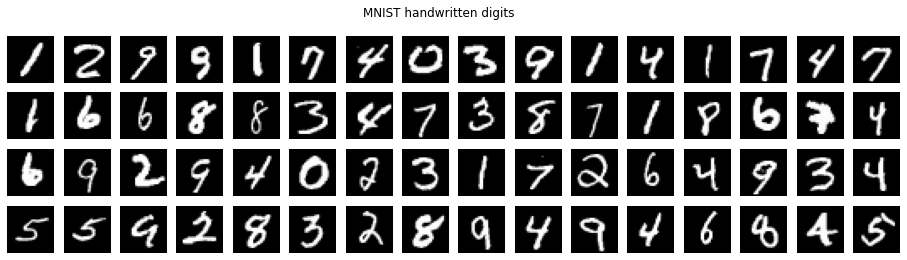

In [5]:
# plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_dataloader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis("off")

plt.suptitle("MNIST handwritten digits")
plt.show()

### Construct a class for autoencoder

Define an autoencoder class with the following dimensions for the hidden layers:  
**Encoder:** $\left[256, 128\right]$  
**Latent dimension:** To be specified by user at the time of initialization  
**Decoder:** $\left[128, 256\right]$ 

Please refer [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), and [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for defining the encoder and decoder. 
The class is to be inherited from the base [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) from PyTorch.

In [6]:
num_input_features = 28 ** 2          # For MNIST data, images of size 28x28 are flattened


class AutoEncoder(nn.Module):
    def __init__(self, num_latent_features):
        super().__init__()

        self.num_latent_features = num_latent_features

        # Encodes data onto the latent space
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=self.num_latent_features),    # Latent Layer
        )

        # Decode latent information into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.num_latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_input_features),
            nn.Sigmoid(),     #Convert outputs to the scale of the inputs, ie, [0, 1]
        )

    def forward(self, x):
        outputs = {}

        z = self.encoder(x)     # Pass input via encoder to get latent representation
        x = self.decoder(z)     # Pass latent rep. to obtain recontructed input

        # Return both the latent rep. and recontructed input
        outputs["x_out"] = x
        outputs["z"] = z

        return outputs

In [7]:
num_latent_features = 10       #Initialize the model with a latent dimension 
ae_model = AutoEncoder(num_latent_features).to(device)
print(ae_model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### Define the loss function and optimizer 

Define a loss function including L1 regularization on latent representation. The weightage of regularization in the total loss is to be controlled.  
Change the values by a factor of 10 for the weightage factor (eg., after a trial with value 1, try 0.1) and select the optimum value.  
Also define an optimizer for updating the parameter weights.

In [8]:
lambda1 = 0.00001


def loss(x_recons, x, z):
    l1_regularization = lambda1 * torch.norm(z, 1)
    bce = binary_cross_entropy(x_recons, x)
    ae_loss = bce + l1_regularization
    return ae_loss


ae_lr = 0.05
ae_sgd_momentum = 0.7
ae_optimizer = optim.SGD(ae_model.parameters(), lr=ae_lr, momentum=ae_sgd_momentum)
ae_loss_function = loss

### Train the auto encoder

Each module inherited from `nn.Module` has a `self.training` attribute which should be set to `True` while training and `False` while testing. You can use the `train()` function to set the model in taining mode and `eval()` function to set the model in testing mode. This is needed because some layers (like batch normalization, droput, etc.) behaves differently while training and testing.  

**Perform the following steps while training the model:**  
* Iterate over batches of input data in each epoch
* PyTorch accumulates the parameter gradients on each subsequent backward pass, thus we need to set the gradients explicitly to zero in each iteration to avoid this. This can be done by calling function `zero_grad()` on the optimizer
* Perform a forward pass in the model with the input batch
* Calculate the loss for this batch of input
* Calculate the gradients for the model parameters in the direction of minimizing the loss. The `backward()` function is used on the loss to calculate this gradients
* Perform the optimization of model parameters using the gradients. The `step()` function is used on the optimizer to update the parameters  

The batch loss and/or epoch loss can be printed out to visualize the training progress.  

**Perform the following while testing the model:** 
* Set the model to testing mode
* Disable the gradient calculation. Take a look at [`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html)
* Calculate the test set loss  

When using a tensor for operations that does not require gradient calculations (for debugging, plotting, etc.), you need to break it from the computational graph. This can be done by calling the `detach()` function on the tensor. A tensor on GPU can be moved to CPU by calling the `cpu()` function on the tensor.

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 1 Average Training loss: 0.0068 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0042 =======


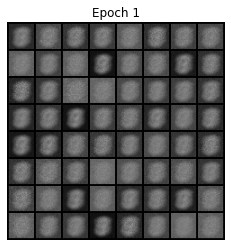

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 2 Average Training loss: 0.0041 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0041 =======


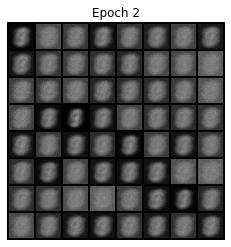

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 3 Average Training loss: 0.0040 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0040 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 4 Average Training loss: 0.0040 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0040 =======


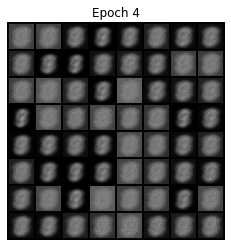

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 5 Average Training loss: 0.0039 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0039 =======


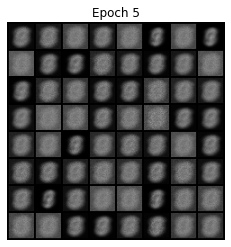

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 6 Average Training loss: 0.0039 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0039 =======


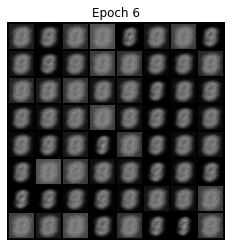

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 7 Average Training loss: 0.0039 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0039 =======


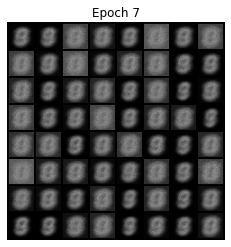

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 8 Average Training loss: 0.0039 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0039 =======


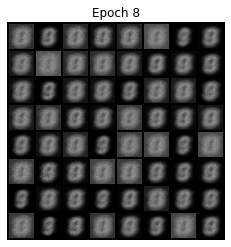

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 9 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0039 =======


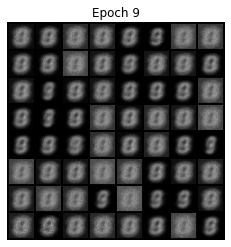

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 10 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0038 =======


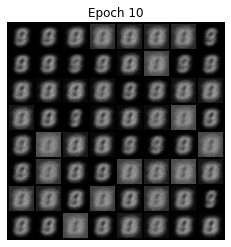

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 11 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0038 =======


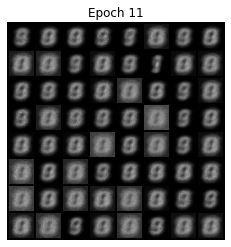

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 12 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0038 =======


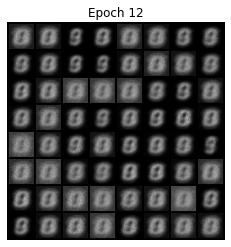

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 13 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0038 =======


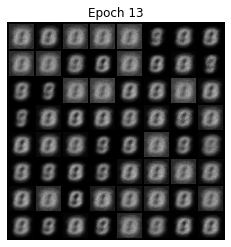

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 14 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0038 =======


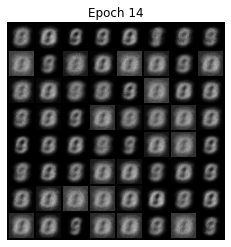

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 15 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0037 =======


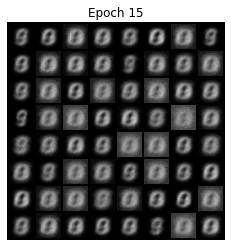

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 16 Average Training loss: 0.0037 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0037 =======


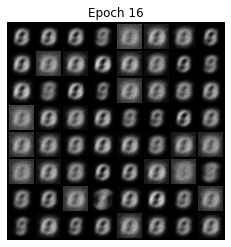

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 17 Average Training loss: 0.0037 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0037 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 18 Average Training loss: 0.0037 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0037 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 19 Average Training loss: 0.0036 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0036 =======


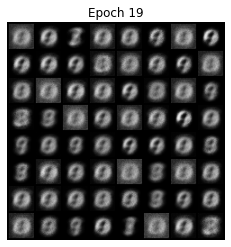

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 20 Average Training loss: 0.0036 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0036 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 21 Average Training loss: 0.0036 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0036 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 22 Average Training loss: 0.0036 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0035 =======


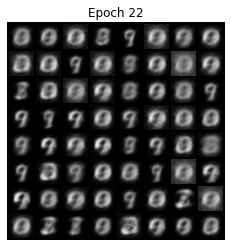

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 23 Average Training loss: 0.0035 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0035 =======


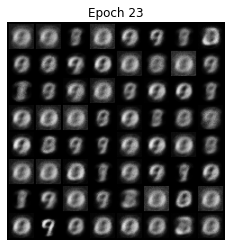

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 24 Average Training loss: 0.0035 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0035 =======


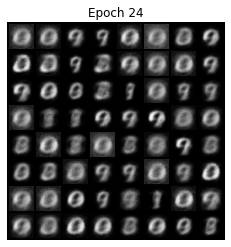

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 25 Average Training loss: 0.0035 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0034 =======


In [9]:
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    ### =====TRAINING=====
    ae_model.train()
    train_loss = 0
    with tqdm(train_dataloader, unit="batch") as train_epoch_pbar:
        for data, labels in train_epoch_pbar:
            train_epoch_pbar.set_description(f"Epoch {epoch}")

            data = data.to(device)
            ae_optimizer.zero_grad()
            outputs = ae_model(data)
            loss = ae_loss_function(outputs["x_out"], data, outputs["z"])
            loss.backward()
            ae_optimizer.step()

            train_loss += loss.item()
            avg_batch_loss = loss.item() / len(data)
            train_epoch_pbar.set_postfix(loss=avg_batch_loss)

        avg_epoch_loss = train_loss / len(train_dataloader.dataset)
        print(
            f"======= Epoch: {epoch} Average Training loss: {avg_epoch_loss:.4f} ======="
        )

    ### =====TESTING=====
    ae_model.eval()
    test_loss = 0
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch") as test_pbar:
            for data, labels in test_pbar:
                data = data.to(device)
                outputs = ae_model(data)
                loss = ae_loss_function(outputs["x_out"], data, outputs["z"])
                test_loss += loss.item()

    test_loss /= len(test_dataloader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")

    # Visualizing training progress
    with torch.no_grad():
        sample = torch.randn(batch_size, num_latent_features).to(device)
        sample = ae_model.decoder(sample).detach().cpu()
        image_grid = make_grid(sample.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        plt.imshow(image_grid.numpy(), cmap="gray", vmin=0, vmax=255)
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()

### Visualizing input data and its reconstruction from the trained model

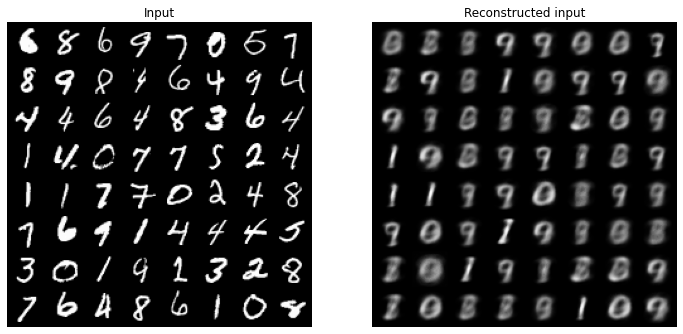

In [10]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = Variable(x)
    x = x.to(device)
    outputs = ae_model(x)
    x_out = outputs["x_out"].detach().cpu()
    x = x.detach().cpu()

    image_grid = make_grid(x.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")

To generate a nice plot, we need sufficient amount of latent data points. This can be done by temporarily increasing the batch size.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


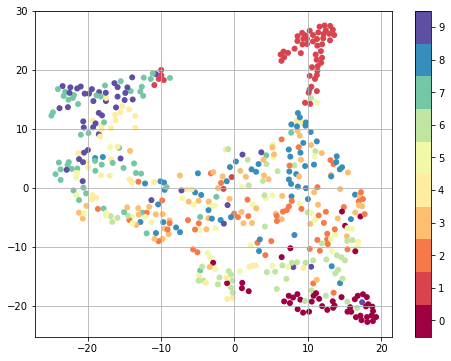

In [12]:
# Increase the batch size for a nicer plot
dataloader = DataLoader(dset_train, batch_size=512, shuffle=True)
visualize_embeddings(ae_model, dataloader)

# Denoising Autoencoder

Denoising autoencoders prevents the model from *learning* the data. The input data is corrupted by noise before passing through the model.   
We define a module for the addition of noise during training process.

In [13]:
normal = torch.distributions.Normal(0.5, 0.5)


class AdditiveGaussianNoise(nn.Module):
    def __init__(self, plot=False):
        super().__init__()
        self.plot = plot

    def forward(self, x):
        if self.training or self.plot:
            device = x.device
            return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)
        else:
            return x

### Construct a class for denoising autoencoder

Change the `AutoEncoder` class previously defined to include the `AdditiveGaussianNoise` defined above.

In [14]:
class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, num_latent_features):
        super().__init__(num_latent_features)

        # Encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            AdditiveGaussianNoise(),
            nn.Linear(in_features=num_input_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=self.num_latent_features),
        )

In [15]:
num_latent_features = 10
dae_model = DenoisingAutoEncoder(num_latent_features).to(device)
print(dae_model)

DenoisingAutoEncoder(
  (encoder): Sequential(
    (0): AdditiveGaussianNoise()
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


### Define the loss function and optimizer

In [16]:
dae_lr = 0.01
dae_sgd_momentum = 0.9
dae_optimizer = optim.SGD(dae_model.parameters(), lr=dae_lr, momentum=dae_sgd_momentum)
dae_loss_function = binary_cross_entropy

### Plot the noisy input data

In [17]:
# plot the noisy examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_dataloader))
noise = AdditiveGaussianNoise(plot=True)
for i, ax in enumerate(axarr.flat):
    ax.imshow(noise(images[i]).view(28, 28), cmap="binary_r")
    ax.axis("off")

plt.suptitle("MNIST digits with added noise")
plt.show()

### Train the denoising autoencoder

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 1 Average Training loss: 0.0068 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0061 =======


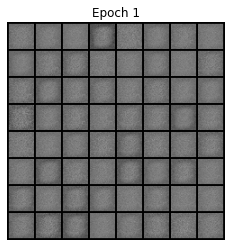

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 2 Average Training loss: 0.0041 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0061 =======


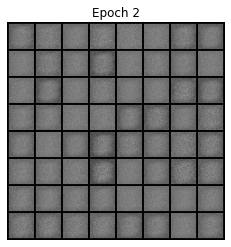

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 3 Average Training loss: 0.0041 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0064 =======


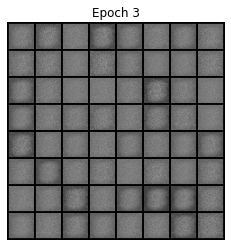

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 4 Average Training loss: 0.0040 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0066 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 5 Average Training loss: 0.0040 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0068 =======


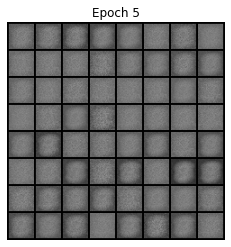

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 6 Average Training loss: 0.0040 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0069 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 7 Average Training loss: 0.0040 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0069 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 8 Average Training loss: 0.0040 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0067 =======


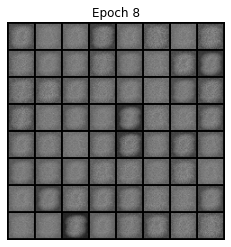

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 9 Average Training loss: 0.0039 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0063 =======


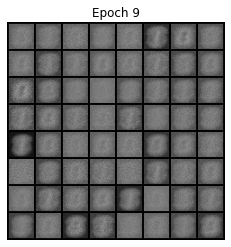

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 10 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0062 =======


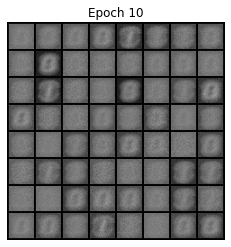

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 11 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0061 =======


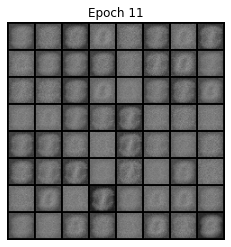

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 12 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0060 =======


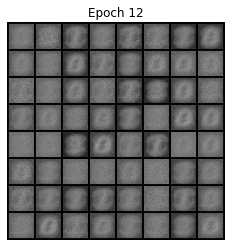

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 13 Average Training loss: 0.0038 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0058 =======


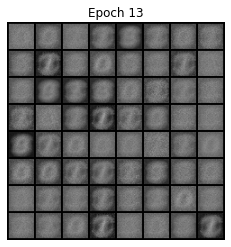

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 14 Average Training loss: 0.0037 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0056 =======


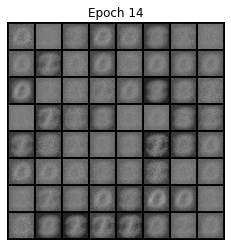

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 15 Average Training loss: 0.0037 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0055 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 16 Average Training loss: 0.0037 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0053 =======


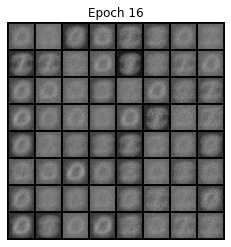

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 17 Average Training loss: 0.0036 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0051 =======


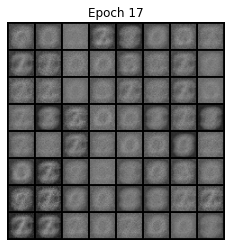

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 18 Average Training loss: 0.0036 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0049 =======


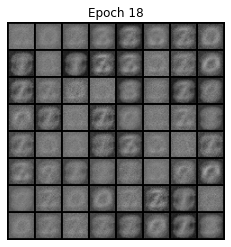

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 19 Average Training loss: 0.0035 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0048 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 20 Average Training loss: 0.0035 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0047 =======


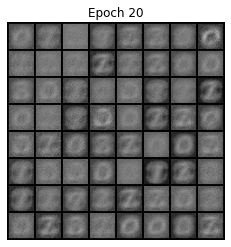

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 21 Average Training loss: 0.0035 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0045 =======


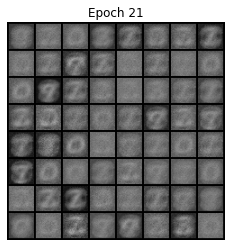

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 22 Average Training loss: 0.0035 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0045 =======


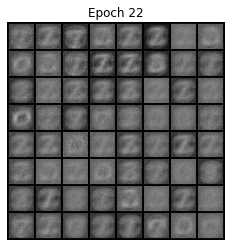

  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 23 Average Training loss: 0.0034 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0043 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 24 Average Training loss: 0.0034 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0042 =======


  0%|          | 0/938 [00:00<?, ?batch/s]

======= Epoch: 25 Average Training loss: 0.0033 =======


  0%|          | 0/157 [00:00<?, ?batch/s]

======= Test set loss: 0.0040 =======


In [18]:
num_epochs = 25
for epoch in range(1, num_epochs + 1):
    ### =====TRAINING=====
    dae_model.train()
    train_loss = 0
    with tqdm(train_dataloader, unit="batch") as train_epoch_pbar:
        for data, labels in train_epoch_pbar:
            train_epoch_pbar.set_description(f"Epoch {epoch}")

            data = data.to(device)
            dae_optimizer.zero_grad()
            outputs = dae_model(data)
            loss = dae_loss_function(outputs["x_out"], data)
            loss.backward()
            dae_optimizer.step()

            train_loss += loss.item()
            avg_batch_loss = loss.item() / len(data)
            train_epoch_pbar.set_postfix(loss=avg_batch_loss)

        avg_epoch_loss = train_loss / len(train_dataloader.dataset)
        print(
            f"======= Epoch: {epoch} Average Training loss: {avg_epoch_loss:.4f} ======="
        )

    ### =====TESTING=====
    dae_model.eval()
    test_loss = 0
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch") as test_pbar:
            for data, labels in test_pbar:
                data = data.to(device)
                outputs = dae_model(data)
                loss = dae_loss_function(outputs["x_out"], data)
                test_loss += loss.item()

    test_loss /= len(test_dataloader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")

    # Visualizing training progress
    with torch.no_grad():
        sample = torch.randn(batch_size, num_latent_features).to(device)
        sample = dae_model.decoder(sample).detach().cpu()
        image_grid = make_grid(sample.view(batch_size, 1, 28, 28), nrow=8).permute(
            1, 2, 0
        )
        plt.imshow(image_grid.numpy(), cmap="gray", vmin=0, vmax=255)
        plt.axis("off")
        plt.title(f"Epoch {epoch}")
        plt.show()

### Visualizing input data and its reconstruction from model

In [19]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = Variable(x)
    x = x.to(device)
    outputs = dae_model(x)
    x_out = outputs["x_out"].detach().cpu()
    x = x.detach().cpu()

    image_grid = make_grid(x.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[0].imshow(image_grid.numpy())
    axarr[0].set_title("Input")
    axarr[0].axis("off")

    image_grid = make_grid(x_out.view(batch_size, 1, 28, 28), nrow=8).permute(1, 2, 0)
    axarr[1].imshow(image_grid.numpy())
    axarr[1].set_title("Reconstructed input")
    axarr[1].axis("off")

### Visualize the latent space embeddings

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


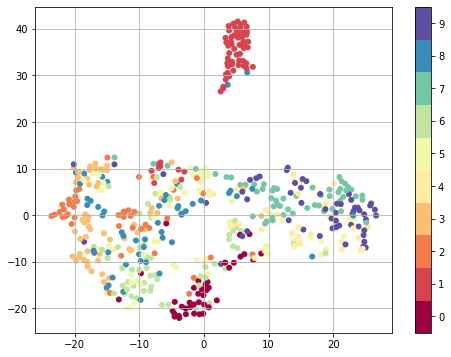

In [20]:
dataloader = DataLoader(dset_train, batch_size=512, shuffle=True)
visualize_embeddings(dae_model, dataloader)